# Group 159 - ? (Front-Facing Baby Chick emoji)
## Short Note 2 - Stacking
Šimon Prasek - 105773
Karel Poncar - 105236
Miroslav Matějček - 105672

This model uses multiple models and stack them together using RidgeCV as the final estimator.

In [1]:
%load_ext autoreload

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
def preprocess(X):
    """Prepare the data to be used in ML models"""

    # Remove NaNs from snow_density
    X['snow_density:kgm3'] = X['snow_density:kgm3'].fillna(0)
    # Interpolate all other NaNs
    X = X.interpolate(axis=0)

    # Make a new row saying only if there is snow, dew or rhime or not
    def is_snow(row):
        if row['fresh_snow_24h:cm'] > 0 or row['snow_depth:cm'] > 0:
            return 1
        else:
            return 0

    X['is_snow'] = X.apply(is_snow, axis=1)

    def is_dew(row):
        return 1 if row['dew_or_rime:idx'] > 0.1 else 0

    def is_rime(row):
        return 1 if row['dew_or_rime:idx'] < -0.1 else 0

    X['is_dew'] = X.apply(is_dew, axis=1)
    X['is_rime'] = X.apply(is_rime, axis=1)

    # Split the date into separate columns
    X['year'] = X['date_forecast'].apply(lambda x: x.year)
    X['day_of_year'] = X['date_forecast'].apply(lambda x: x.dayofyear)
    X['hour_of_day'] = X['date_forecast'].apply(lambda x: x.hour)

    # Drop columns that seems to be unnecessary
    columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm', 'fresh_snow_12h:cm', 'fresh_snow_3h:cm',
                       'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 'snow_water:kgm2', 'snow_density:kgm3',
                       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms',
                       'wind_speed_10m:ms', 'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa',
                       'dew_or_rime:idx', 'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J',
                       'direct_rad_1h:J', 'dew_point_2m:K']
    columns_to_drop += ['super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p']
    X.drop(columns=columns_to_drop, inplace=True)
    X.drop(["date_calc"], axis=1, inplace=True, errors='ignore')
    X['ones'] = 1
    return X


def make_y_15mins(y):
    """ We have weather data for every 15 min, but energy production data only every hour, so we copy every row 4 times"""
    y = y.loc[y.index.repeat(4)].reset_index(drop=True)
    y['time'] += y.groupby(y.index // 4).cumcount() * pd.Timedelta("15 min")

    y = y.dropna()
    return y


def match_x_and_y(X, y):
    """Take only dates with both weather and pover production data"""
    y = y.dropna()
    X = X[X['date_forecast'].isin(y['time'])].reset_index(drop=True)
    y = y[y['time'].isin(X['date_forecast'])].reset_index(drop=True)
    return X, y


def mean_15min_output(y):
    """We have predictions for every 15 minutes, so we take average of this results"""
    y[y < 0.] = 0
    meany = np.zeros(y.shape[0] // 4)

    for i in range(meany.shape[0]):
        meany[i] = np.mean(y[4 * i: 4 * (i + 1)])
    return meany


In [4]:
prediction = []
models = []

# Prepare pipelines with data normalisation for linear models
linreg_pipeline = make_pipeline(
    StandardScaler(), LinearRegression()
)
lasso_pipeline = make_pipeline(
    StandardScaler(), LassoCV()
)

# Prepare estimators
estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', lasso_pipeline),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=42)),
              ('Linear Regression', linreg_pipeline),
              ('Adaboost', AdaBoostRegressor(random_state=42)),
              ]

# Train them for every location separately
for letter in ['A', 'B', 'C']:
    # Read the data
    print(f"Training on dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")

    # Prepare them for training
    y_train = make_y_15mins(y_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = X_test.drop('date_calc', axis=1)
    X_test = preprocess(X_test)

    # Create the predictor
    stacking_regressor = StackingRegressor(estimators=estimators,
                                           final_estimator=RidgeCV())
    # Train the model
    model = stacking_regressor.fit(X_train, y_train['pv_measurement'])
    models.append(model)
    # Make the predictions
    print(f"{mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement']))=}")
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))

# Store the results into csv
prediction = mean_15min_output(prediction)
prediction[prediction < 0.] = 0.  # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('final2.csv', index_label='id')
print("done")


Training on dataset A
mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement']))=161.73274287805526
Training on dataset B
mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement']))=54.85634647841876
Training on dataset C
mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement']))=19.493379000670103
done


# Some visualisations of the model

In [6]:
model = models[2]
model

StackingRegressor(estimators=[('Random Forest',
                               RandomForestRegressor(random_state=42)),
                              ('Lasso',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('lassocv', LassoCV())])),
                              ('Gradient Boosting',
                               HistGradientBoostingRegressor(random_state=42)),
                              ('Linear Regression',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('linearregression',
                                                LinearRegression())])),
                              ('Adaboost', AdaBoostRegressor(random_state=42))],
                  final_estimator=RidgeCV())

In [ ]:
model = model[0]
model.final

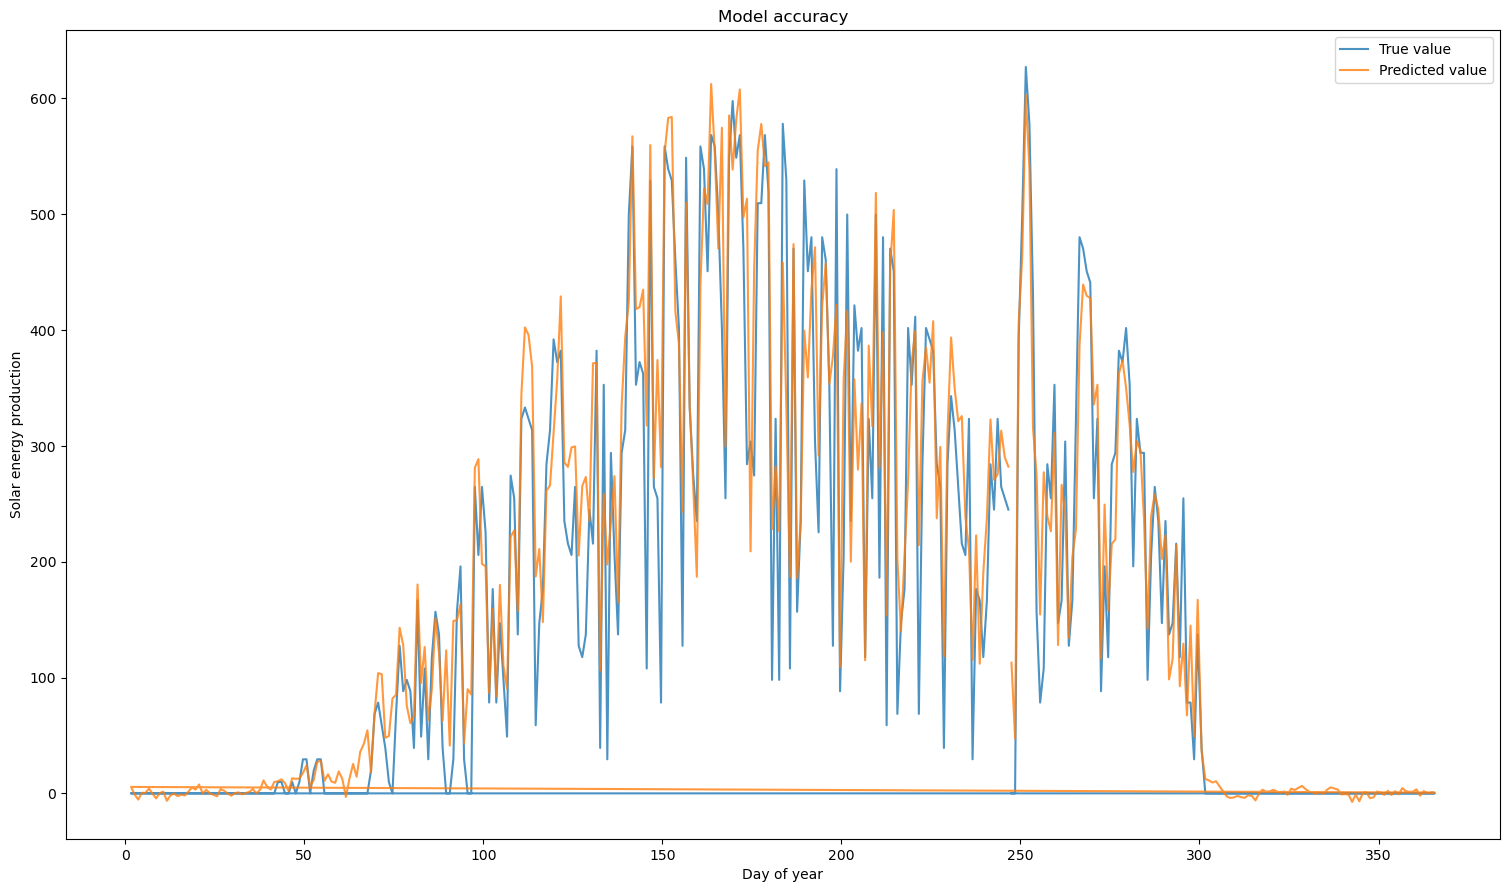

In [53]:
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes 
fig.set_size_inches(18.5, 10.5, forward=True)
plt.plot(X_train[4*4:365*24*4:24*4]['day_of_year']+(1/24)*X_train[4*4:365*24*4:24*4]['hour_of_day'], y_train[4*4:365*24*4:24*4]['pv_measurement'], alpha=0.8, label='True value', linestyle='solid')
plt.plot(X_train[4*4:365*24*4:24*4]['day_of_year']+(1/24)*X_train[4*4:365*24*4:24*4]['hour_of_day'], model.predict(X_train[4*4:365*24*4:24*4]), alpha=0.8, label='Predicted value', linestyle='solid')
plt.xlabel('Day of year')
plt.ylabel('Solar energy production')
plt.title('Model accuracy')
plt.legend()


plt.show()



In [68]:
print('Coefficients of the final estimator:')
pd.DataFrame(model.final_estimator_.coef_, model.named_estimators_.keys())

Coefficients of the final estimator:


,0
Random Forest,0.045709
Lasso,-0.433000
Gradient Boosting,0.743400
Linear Regression,0.629035
Adaboost,0.014400


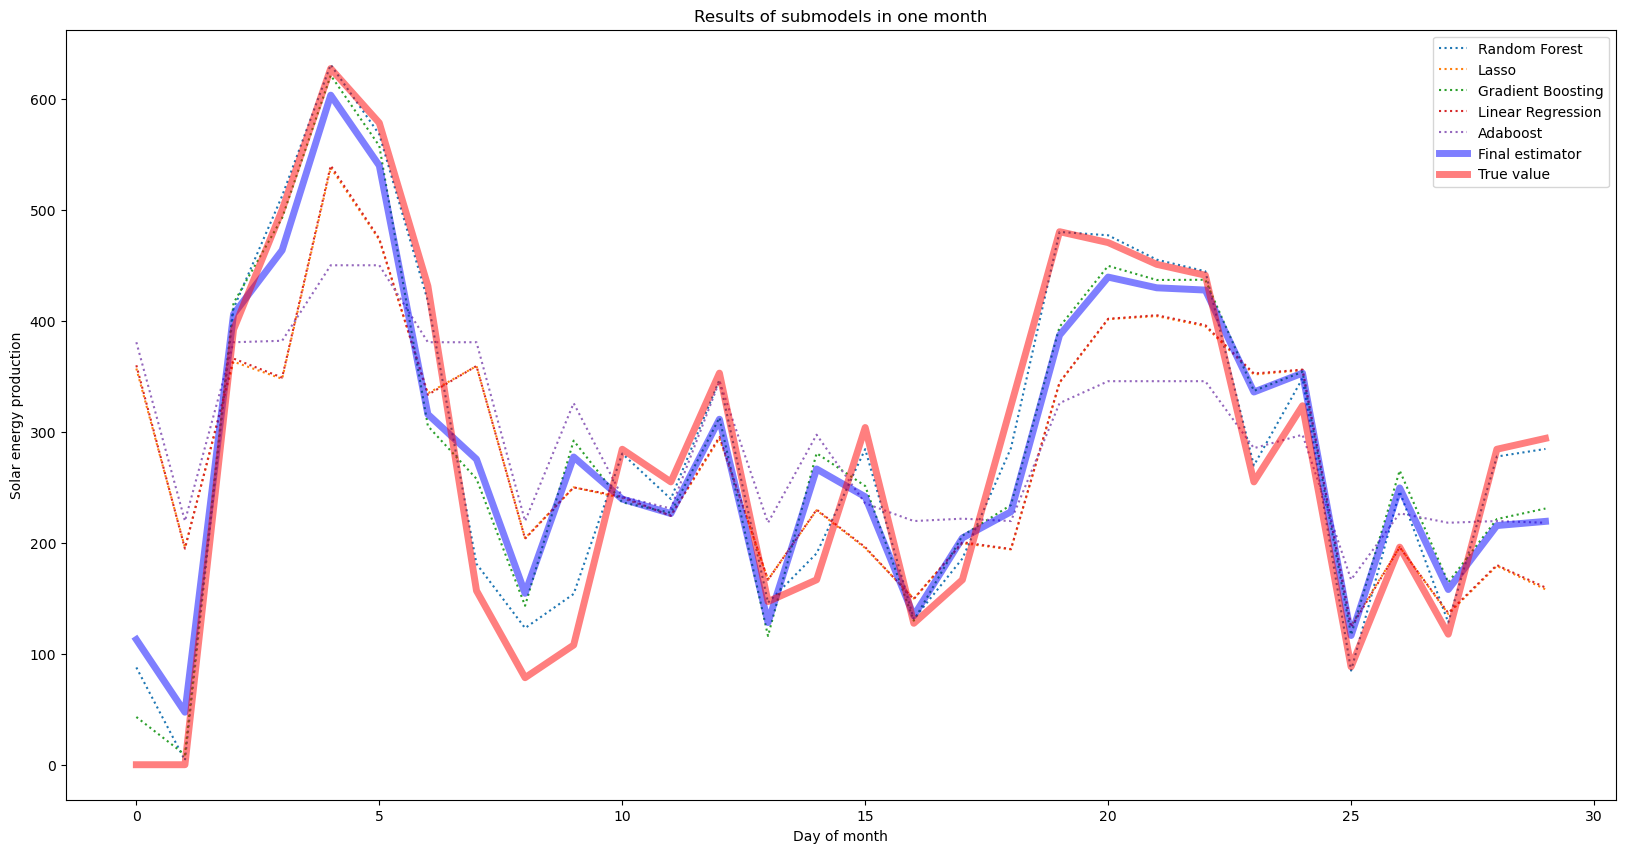

In [106]:
fig = plt.figure(figsize=(20,10))
plt.plot(model.transform(X_train)[4*4:30*4*24:24*4], label=model.named_estimators_.keys (), linestyle='dotted')
plt.plot(np.array(model.predict(X_train)[4*4:30*4*24:24*4]), label='Final estimator', linewidth=5, color='b', alpha=0.5)
plt.plot(np.array(y_train['pv_measurement'])[4*4:30*4*24:24*4], label='True value', linewidth=5, color='r', alpha=0.5)
plt.legend()
plt.title('Results of submodels in one month')
plt.xlabel('Day of month')
plt.ylabel('Solar energy production')
plt.show()